# Telluric Emulator experiment!

March 2022

gully


The goal of the notebook is to make a figure for the paper showing how we clone the precomputed synthetic model.

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import PhoenixEmulator, SparsePhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import os

import copy
import seaborn as sns

sns.set_context('paper', font_scale=1.3)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cpu'

### Rebrand `SparsePHOENIXEmulator` to `TelluricEmulator`

They're now so similar that **no code change** is needed!

In [4]:
TelluricEmulator = SparsePhoenixEmulator

### Retrieve the TelFit Model

In [5]:
#! ls /media/gully/pecos/libraries/raw/telfit/grid_v1p0/telfit_800_1300nm_temp270_hum055.txt

In [6]:
#fn = '/media/gully/pecos/libraries/raw/telfit/grid_v1p0/telfit_800_1300nm_temp270_hum055.txt'
fn = '/Volumes/pecos/libraries/raw/telfit/grid_v1p0/telfit_800_1300nm_temp270_hum055.txt'

In [7]:
df = pd.read_csv(fn, delim_whitespace=True, names=['wl_nm', 'flux', 'junk1', 'junk2'], usecols=['wl_nm', 'flux'])

In [8]:
df['wl'] = df['wl_nm'] * 10.0

(0.0, 1.1)

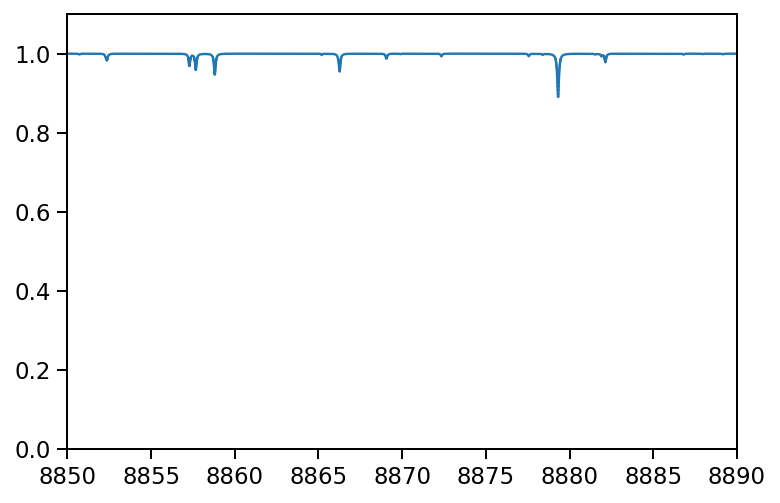

In [9]:
plt.step(df.wl, df.flux)
plt.xlim(8850, 8890)
plt.ylim(0, 1.1)

In [10]:
df.shape

(2073218, 3)

### Retrieve the Phoenix model

In [11]:
spectrum = PHOENIXSpectrum(teff=4700, logg=4.5)#, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [12]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value.astype(np.float64)
flux_native = spectrum.flux.value

### Clone the Stellar model

In [13]:
emulator = SparsePhoenixEmulator(wl_native, flux_native, prominence=0.01)

Initializing a sparse model with 9028 spectral lines


In [14]:
emulator.to(device)

SparsePhoenixEmulator()

In [15]:
state_dict_init = copy.deepcopy(emulator.state_dict())
state_dict_init['lam_centers'].shape

torch.Size([9028])

In [16]:
pretrained_model_fn = '../experiments/04_full_bandwidth_HPF/emulator_T4700g4p5_prom0p01_HPF.pt'
state_dict_post = torch.load(pretrained_model_fn, 
                            map_location=torch.device('cpu'))

In [17]:
emulator_post = copy.deepcopy(emulator)

In [18]:
emulator_post.load_state_dict(state_dict_post)

<All keys matched successfully>

In [19]:
%%time
with torch.no_grad():
    spec_out = emulator_post.forward().cpu().numpy()

CPU times: user 1.56 s, sys: 1.11 s, total: 2.66 s
Wall time: 522 ms


In [20]:
residual = flux_native - spec_out

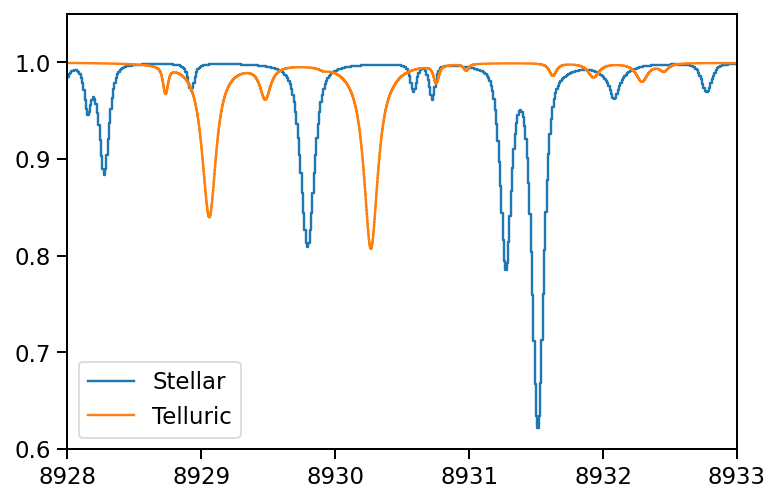

In [21]:
plt.step(wl_native, spec_out, label='Stellar')
plt.step(df.wl, df.flux, label='Telluric')
#plt.xlim(8875, 8884)
plt.xlim(8928, 8933)
plt.ylim(0.6)
plt.legend()

## Clone the Telluric model

In [22]:
wl_telluric = df.wl.values
flux_telluric = df.flux.values

In [23]:
telluric_emulator = TelluricEmulator(wl_telluric, flux_telluric, wing_cut_pixels=6000, device=device)

Initializing a sparse model with 2946 spectral lines


In [24]:
telluric_emulator.to(device)

SparsePhoenixEmulator()

In [25]:
%%time
with torch.no_grad():
    tell_out = telluric_emulator.forward().cpu().numpy()

CPU times: user 2.89 s, sys: 2.02 s, total: 4.91 s
Wall time: 1.17 s


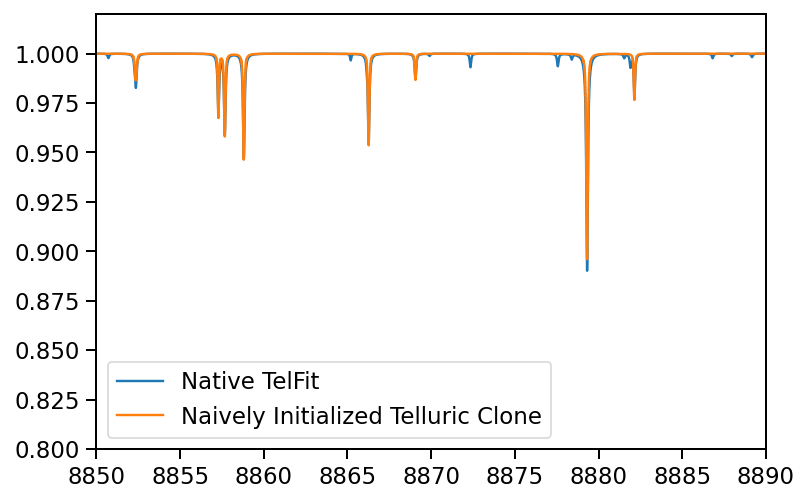

In [26]:
plt.plot(wl_telluric, flux_telluric, label='Native TelFit')
plt.step(wl_telluric, tell_out, label='Naively Initialized Telluric Clone')
plt.xlim(8850, 8890)
plt.ylim(0.8, 1.02)
plt.legend()

## Train the telluric model clone

In [27]:
wl_telluric = telluric_emulator.wl_native.clone().detach().to(device)
wl_active = wl_telluric.to("cpu")[telluric_emulator.active_mask.to("cpu").numpy()]
target = (
    telluric_emulator.flux_native.clone().detach().to(device)[telluric_emulator.active_mask.cpu().numpy()]
)


In [28]:
telluric_emulator.radial_velocity.requires_grad = False
telluric_emulator.lam_centers.requires_grad = False
telluric_emulator.amplitudes.requires_grad = True
telluric_emulator.sigma_widths.requires_grad = True
telluric_emulator.gamma_widths.requires_grad = True

In [29]:
import os
import torch
from torch import nn
from tqdm import trange
import torch.optim as optim
import numpy as np

In [30]:
loss_fn = nn.MSELoss(reduction="mean")

optimizer = optim.Adam(
    list(filter(lambda p: p.requires_grad, telluric_emulator.parameters())), 0.01, amsgrad=True,
)
n_epochs = 1000
losses = []

target = target.to(device)

t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    telluric_emulator.train()
    high_res_model = telluric_emulator.forward()[telluric_emulator.active_mask]
    loss = loss_fn(high_res_model, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 0.00016417: 100%|████████████| 1000/1000 [01:59<00:00,  8.36it/s]


In [31]:
%%time
with torch.no_grad():
    tell_post = telluric_emulator.forward().cpu().numpy()

CPU times: user 32.9 ms, sys: 4.03 ms, total: 37 ms
Wall time: 35.4 ms


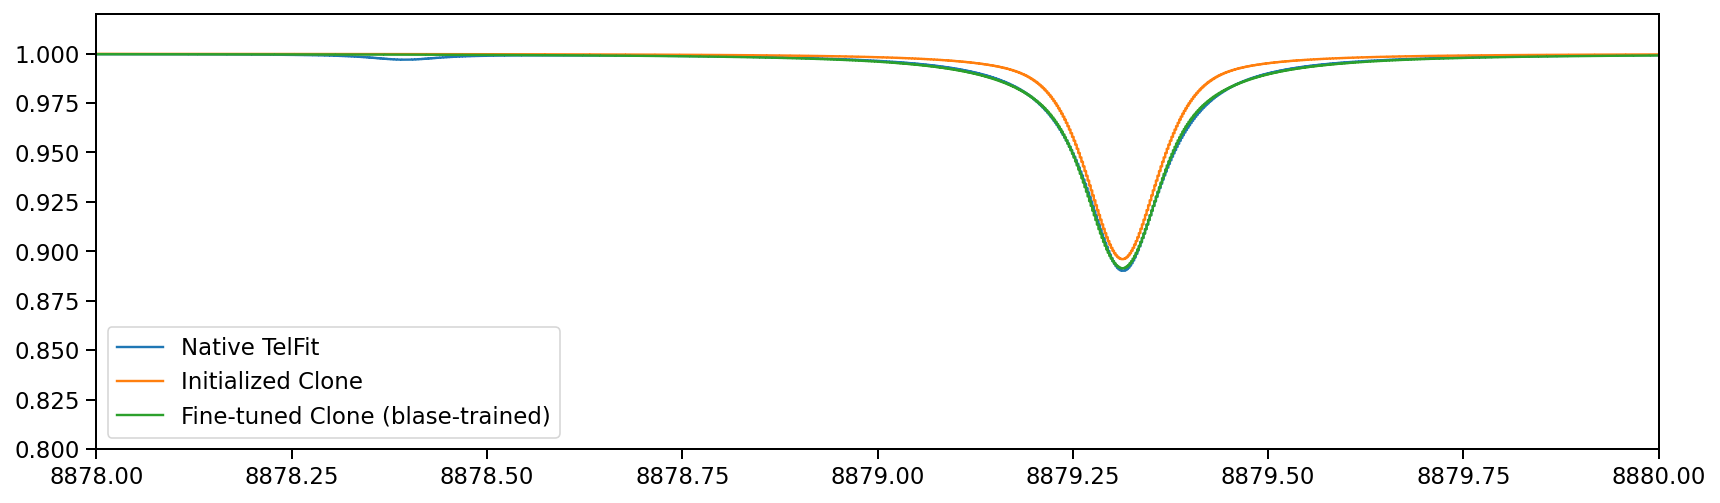

In [32]:
plt.figure(figsize=(14, 4))
plt.step(wl_telluric.cpu(), flux_telluric, label='Native TelFit')
plt.step(wl_telluric.cpu(), tell_out, label='Initialized Clone')
plt.step(wl_telluric.cpu(), tell_post, label='Fine-tuned Clone (blase-trained)')
plt.xlim(8878, 8880)
plt.ylim(0.8, 1.02)
plt.legend()

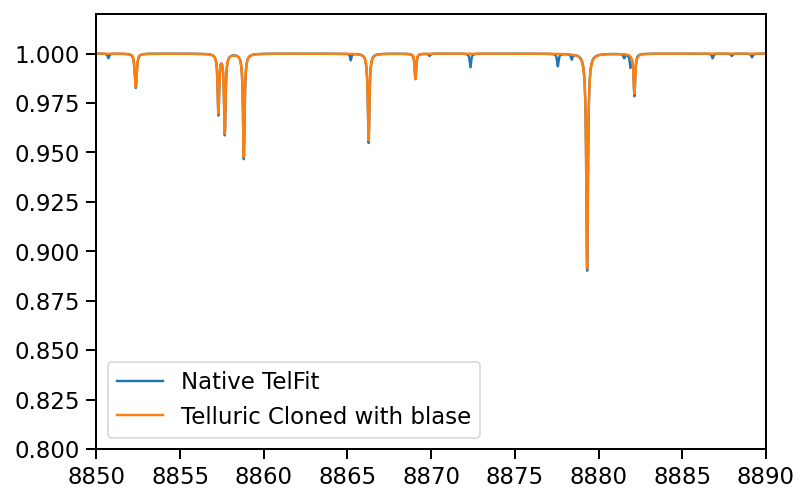

In [33]:
plt.plot(wl_telluric.cpu(), flux_telluric, label='Native TelFit')
plt.step(wl_telluric.cpu(), tell_post, label='Telluric Cloned with blase')
plt.xlim(8850, 8890)
plt.ylim(0.8, 1.02)
plt.legend()

In [34]:
target

tensor([1.0000, 1.0000, 1.0000,  ..., 0.9853, 0.9861, 0.9868], device='cuda:0',
       dtype=torch.float64)

In [35]:
residual = target.cpu() - tell_post[telluric_emulator.active_mask.cpu().numpy()]

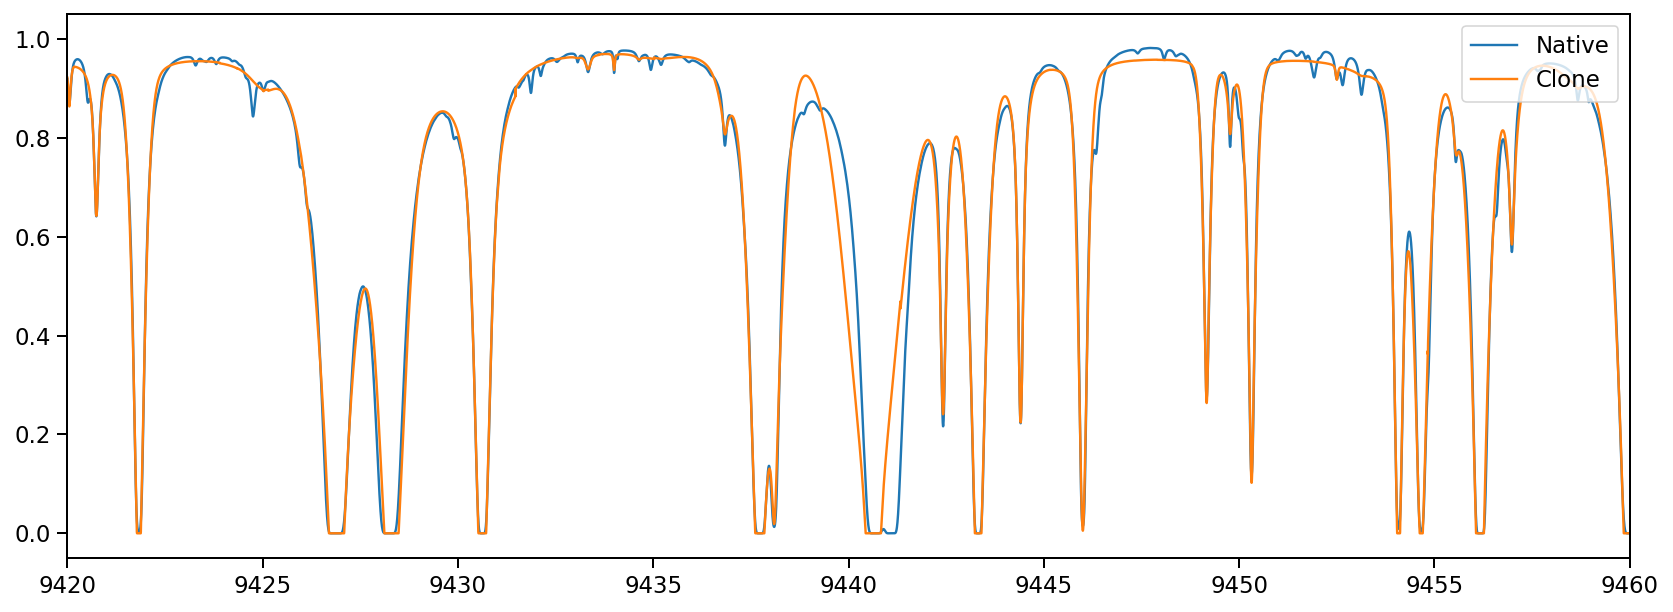

In [36]:
plt.figure(figsize=(14, 5))
#plt.plot(wl_telluric[telluric_emulator.active_mask.cpu().numpy()].cpu(), residual.cpu()-0.5)
plt.plot(wl_telluric.cpu(), flux_telluric, label='Native')
plt.plot(wl_telluric.cpu(), tell_post, label='Clone')
plt.xlim(9420, 9460)
plt.legend(loc='upper right')

No handles with labels found to put in legend.


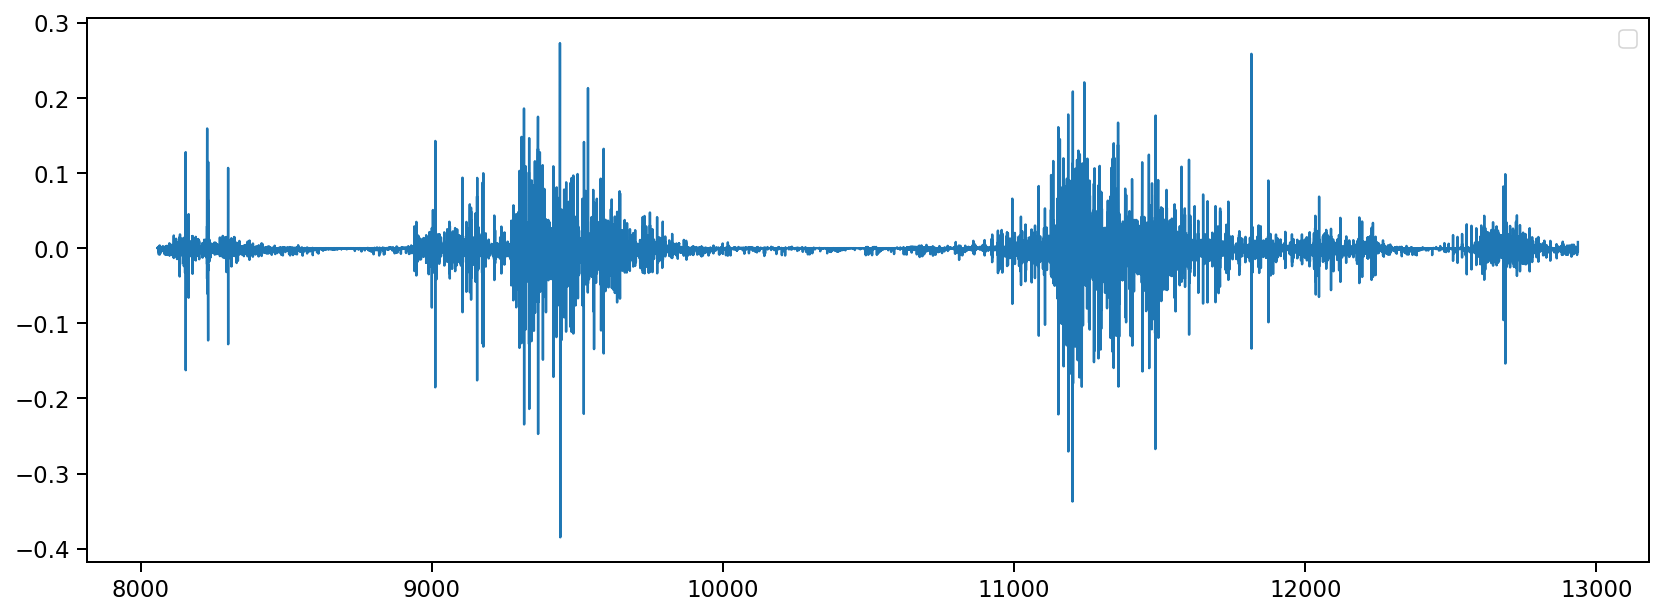

In [37]:
plt.figure(figsize=(14, 5))
plt.plot(wl_telluric[telluric_emulator.active_mask.cpu().numpy()].cpu(), residual.cpu())
#plt.xlim(9420, 9460)
plt.legend(loc='upper right')

In [ ]:
plt.hist(residual, bins=np.arange(-1, 1, 0.003));

## Get a spectrum of WASP-69

In [22]:
import pandas as pd

In [23]:
df_log = pd.read_csv('../../blimp/data/tables/003_goldilocks_PSU_dropbox_1081x30_v1p0.csv')

In [24]:
mask = df_log.OBJECT.str.contains('69')

In [25]:
df_log = df_log[mask].dropna().reset_index(drop=True)

In [26]:
df_log.OBJECT.value_counts()

WASP_69_in_2              7
WASP_69_out_2_before_4    4
WASP_69_out_1_before_4    4
WASP_69_out_2_before_3    3
WASP_69_out_2_before_1    1
Name: OBJECT, dtype: int64

In [27]:
base_path = '/media/gully/pecos/HPF/Dropbox/Helium-transit-data/'
base_path = '/Volumes/pecos/HPF/Dropbox/Helium-transit-data/'

In [28]:
df_log['absolute_path'] = base_path + df_log.dropbox_subfolder_Goldilocks + df_log.file_basename_Goldilocks

In [29]:
fn = df_log.absolute_path[0]

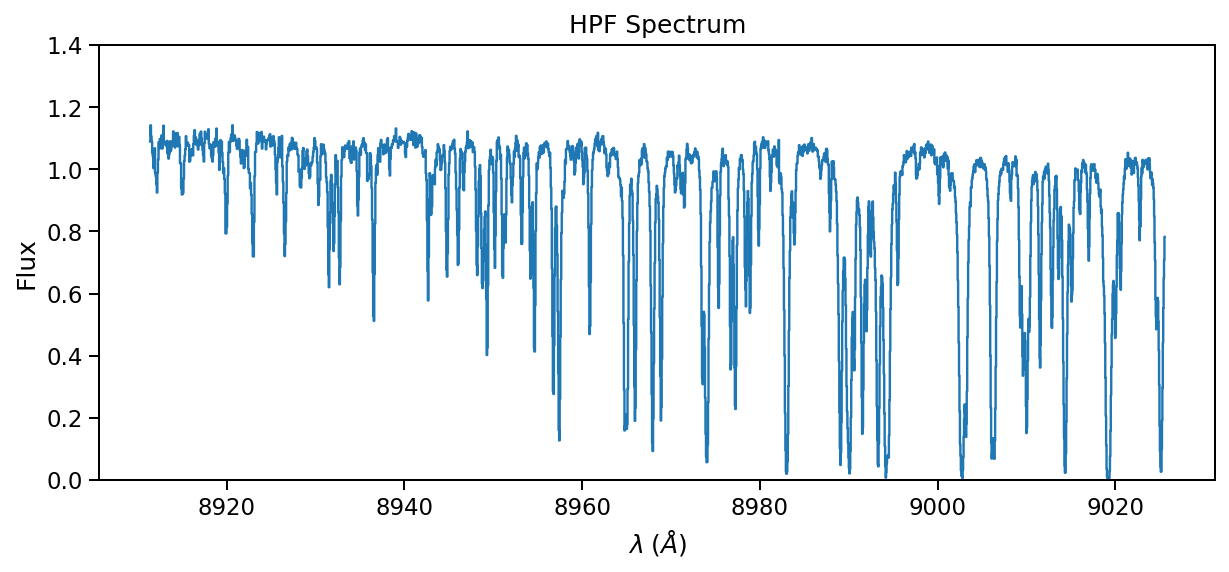

In [30]:
from muler.hpf import HPFSpectrum

data = HPFSpectrum(file=fn, order=7)

data = data.sky_subtract().deblaze().trim_edges((8, 2040)).normalize()
#data = data.mask_tellurics(threshold=0.98)
ax = data.plot(ylo=0, yhi=1.4, label='data')


Save data figure

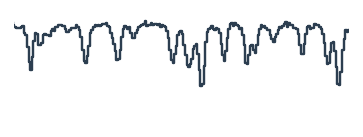

In [50]:
plt.figure(figsize=(3, 1))
plt.step(data.wavelength, data.flux, label='Data', color='#2c3e50')
#plt.step(spectrum.wavelength*1.000055, spectrum.flux, label = 'Star Model')
#plt.step(df.wl*1.00027, df.flux, label = 'Telluric Model')
#plt.xlim(8920, 8999)
plt.xlim(8942, 8955)
plt.ylim(0.0)
plt.axis('off');
plt.savefig('../paper/illustrator_schematic_01/Data.pdf',transparent=True)

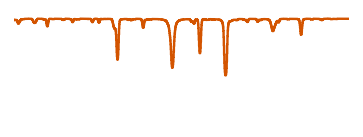

In [51]:
plt.figure(figsize=(3, 1))
#plt.step(data.wavelength, data.flux, label='Data')
plt.step(spectrum.wavelength*1.000055, spectrum.flux, label = 'Star Model', color='#d35400')
#plt.step(df.wl*1.00027, df.flux, label = 'Telluric Model')
#plt.xlim(8920, 8999)
plt.xlim(8942, 8955)
plt.ylim(0.0)
plt.axis('off');
plt.savefig('../paper/illustrator_schematic_01/StellarNative.pdf', transparent=True)

In [55]:
spec_alt = spectrum.rotationally_broaden(4)

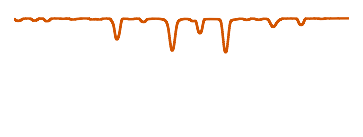

In [56]:
plt.figure(figsize=(3, 1))
#plt.step(data.wavelength, data.flux, label='Data')
plt.step(spec_alt.wavelength*1.000055, spec_alt.flux, label = 'Star Model', color='#d35400')
#plt.step(df.wl*1.00027, df.flux, label = 'Telluric Model')
#plt.xlim(8920, 8999)
plt.xlim(8942, 8955)
plt.ylim(0.0)
plt.axis('off');
plt.savefig('../paper/illustrator_schematic_01/StellarRotBroad.pdf', transparent=True)

In [57]:
from specutils import Spectrum1D

In [58]:
import astropy.units as u

In [60]:
spec_tell_raw = Spectrum1D(spectral_axis=df.wl.values*1.00027*u.Angstrom, 
                       flux=df.flux.values*u.dimensionless_unscaled)

In [61]:
stellar_resampled = spec_alt.resample(spec_tell_raw)

In [62]:
comb = stellar_resampled*spec_tell_raw

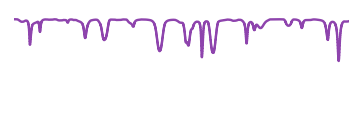

In [71]:
plt.figure(figsize=(3, 1))
#plt.step(data.wavelength, data.flux, label='Data')
plt.step(comb.wavelength, comb.flux, label = 'Combined Model', color='#8e44ad')

#plt.xlim(8920, 8999)
plt.xlim(8942, 8955)
plt.ylim(0.0)
plt.axis('off');
plt.savefig('../paper/illustrator_schematic_01/JointModel.pdf', transparent=True)

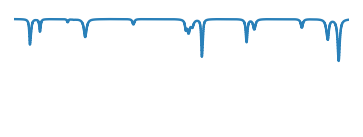

In [67]:
plt.figure(figsize=(3, 1))
#plt.step(data.wavelength, data.flux, label='Data')
#plt.step(spectrum.wavelength*1.000055, spectrum.flux, label = 'Star Model')
plt.step(df.wl*1.00027, df.flux, label = 'Telluric Model', color='#2980b9')
#plt.xlim(8920, 8999)
plt.xlim(8942, 8955)
plt.ylim(0.0)
plt.axis('off');
plt.savefig('../paper/illustrator_schematic_01/TelluricNative.pdf', transparent=True)

In [69]:
comb_resampled = comb.instrumental_broaden().resample(data)

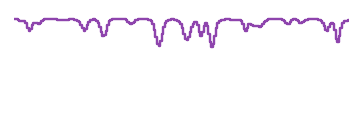

In [72]:
plt.figure(figsize=(3, 1))
#plt.step(data.wavelength, data.flux, label='Data')
plt.step(comb_resampled.wavelength, comb_resampled.flux, 
         label = 'Combined Resampled Model', color='#8e44ad')
#plt.xlim(8920, 8999)
plt.xlim(8942, 8955)
plt.ylim(0.0)
plt.axis('off');
plt.savefig('../paper/illustrator_schematic_01/ModelJointResampled.pdf', transparent=True)

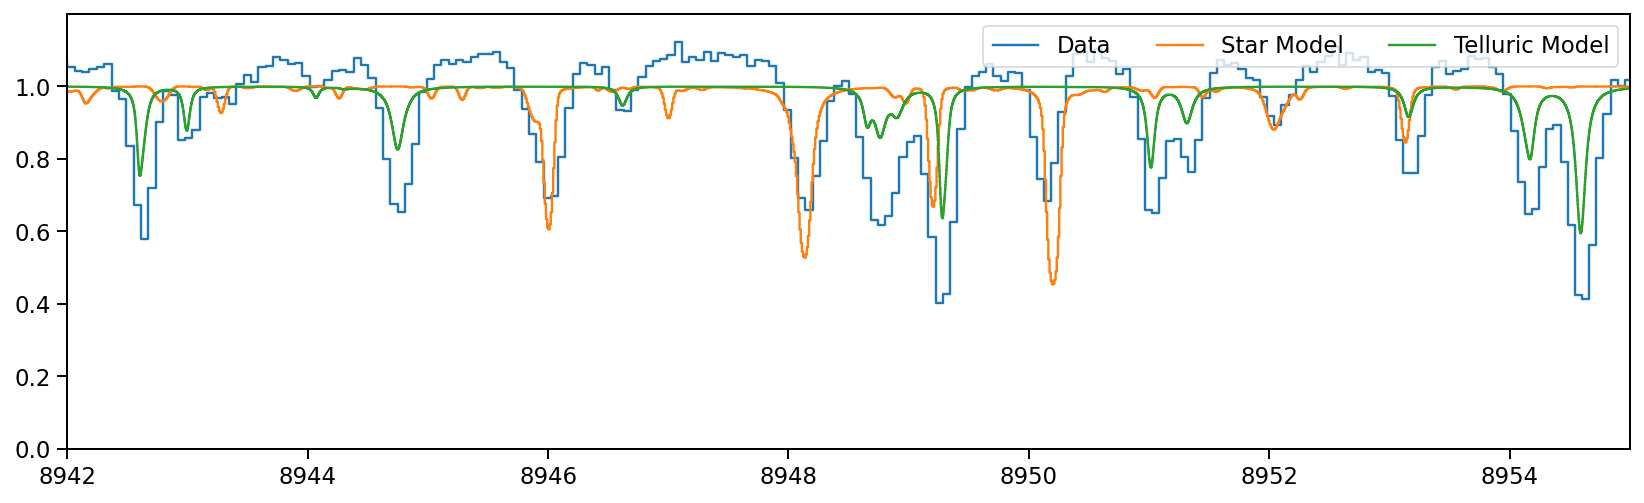

In [64]:
plt.figure(figsize=(14, 4))
plt.step(data.wavelength, data.flux, label='Data')
plt.step(spectrum.wavelength*1.000055, spectrum.flux, label = 'Star Model')
plt.step(df.wl*1.00027, df.flux, label = 'Telluric Model')
#plt.xlim(8920, 8999)
plt.xlim(8942, 8955)
plt.ylim(0.0)
plt.legend(loc='upper right', ncol=3)

In [32]:
len(df)

2073218

In [33]:
data_list = []
for i, fn in enumerate(df.absolute_path.values):
    data = HPFSpectrum(file=fn, order=5)

    data = data.sky_subtract().deblaze().trim_edges((8, 2040)).barycentric_correct().normalize()
    data = data.mask_tellurics(threshold=0.98)
    data_list.append(data)

AttributeError: 'DataFrame' object has no attribute 'absolute_path'

In [31]:
from muler.utilities import combine_spectra_misaligned

In [32]:
pixel_midpoints = HPFSpectrum(file=fn, order=5).wavelength.value

In [33]:
comb_spec = combine_spectra_misaligned(data_list, pixel_midpoints=pixel_midpoints)

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

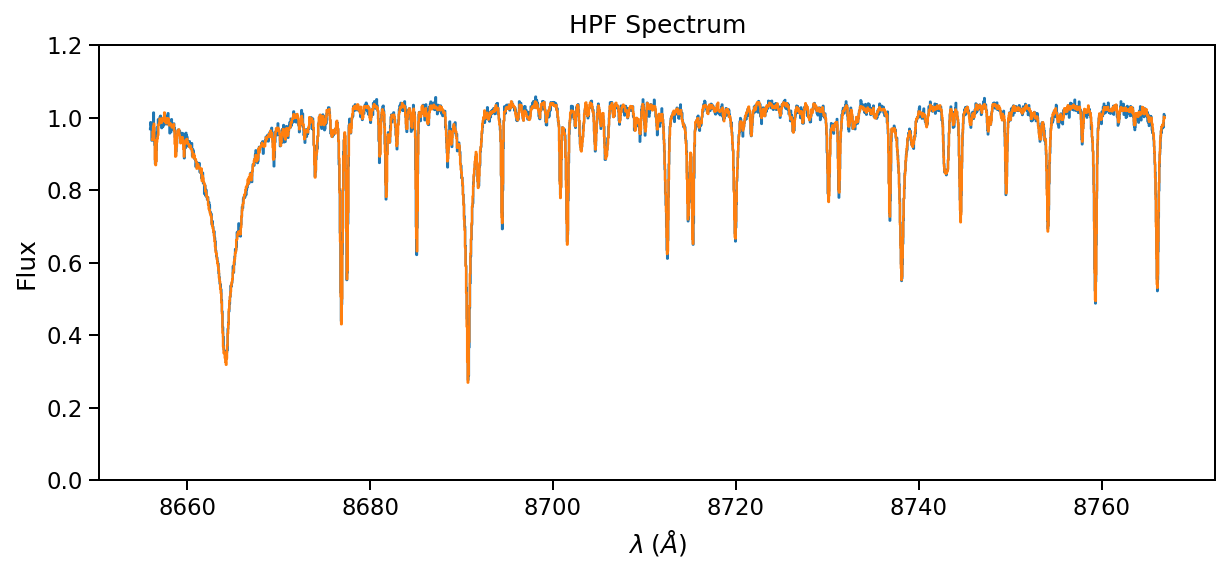

In [34]:
ax = data.plot(ylo=0)
comb_spec.plot(ax=ax)
#ax.set_xlim(8580, 8600)

In [35]:
#comb_spec.write('../data/WASP_69_hpf_stack.fits')

In [38]:
import astropy.units as u

In [40]:
# We will demo on WASP 69
#hdus = fits.open("../data/WASP_69_hpf_stack.fits")

#data = HPFSpectrum(flux=hdus[1].data["flux"]*u.dimensionless_unscaled, 
#                   spectral_axis=hdus[1].data["wavelength"]*u.Angstrom)
#data = data.remove_nans()

In [41]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

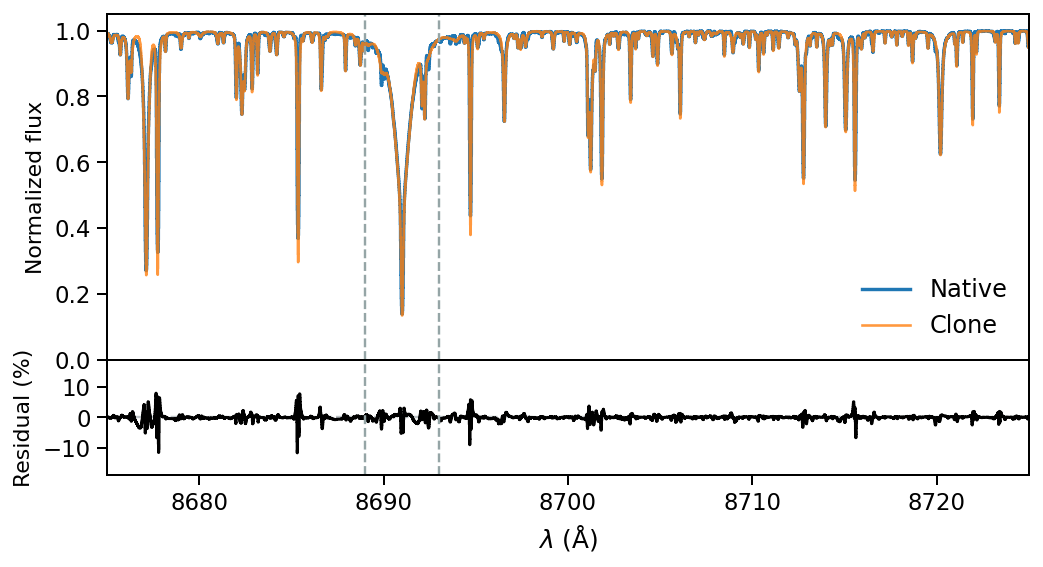

In [31]:
fig = plt.figure(figsize=(8, 4))

wl_lo = 8675#data.wavelength.value.min()+20
wl_hi = 8725#data.wavelength.value.max()-50

# Data - model comparison
ax = fig.add_axes((.1,.3,.8,.6))
ax.set_xticklabels([])
ax.step(wl_native, flux_native, alpha=1, lw=1.7, label='Native')
ax.step(wl_native, spec_out, alpha=0.8, lw=1.3, label='Clone')

ax.set_xlim(wl_lo, wl_hi)
ax.axvline(8689, linestyle='dashed', color='#95a5a6')
ax.axvline(8693, linestyle='dashed', color='#95a5a6')
ax.legend(fontsize=12, loc='best', ncol=1, frameon=False)
ax.set_ylim(-0.0001, 1.05)

ax.set_ylabel('Normalized flux', fontsize=11);

# Residual plot 
ax2=fig.add_axes((.1,.1,.8,.2))    
ax2.axhline(0, linestyle='dashed', color='#bdc3c7')
ax2.step(wl_native, residual*100, alpha=1, color='k', lw=1.5)
ax2.set_xlim(wl_lo, wl_hi)
ax2.set_ylim(-19, 19)
ax2.axvline(8689, linestyle='dashed', color='#95a5a6')
ax2.axvline(8693, linestyle='dashed', color='#95a5a6')
ax2.set_ylabel('Residual (%)', fontsize=11)
ax2.set_xlabel(r'$\lambda$ ($\mathrm{\AA}$)')
plt.savefig('../paper/paper1/figures/blase_clone_demo.png', bbox_inches='tight', dpi=300);

In [34]:
pixels = (wl_native < wl_hi) & (wl_native >wl_lo)

In [41]:
np.max(residual)

0.2573512768195079

In [35]:
np.std(residual), np.std(residual[pixels])

(0.012750119104176524, 0.010696828004524822)

Nice!

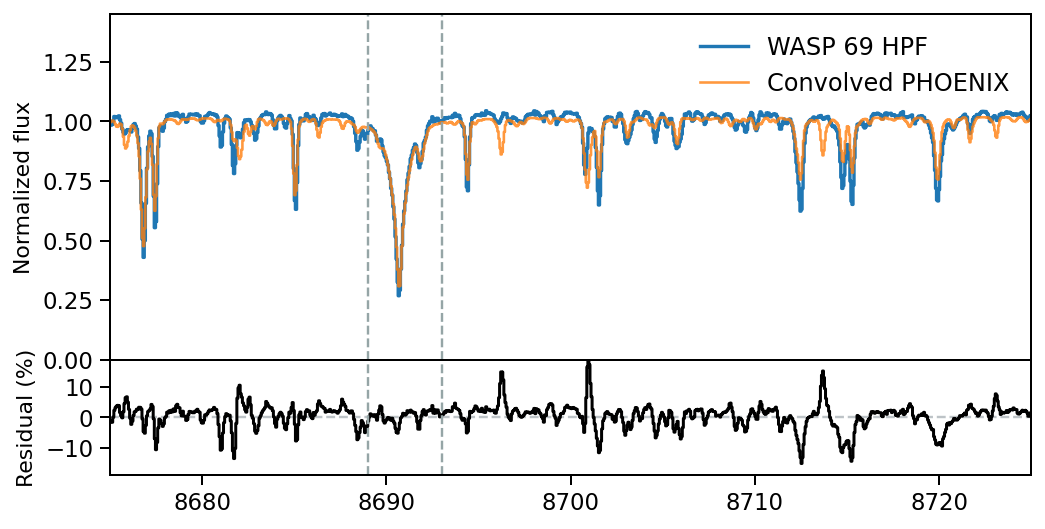

In [43]:
fig = plt.figure(figsize=(8, 4))

# Data - model comparison
ax = fig.add_axes((.1,.3,.8,.6))
ax.set_xticklabels([])
ax.step(comb_spec.wavelength, comb_spec.flux, alpha=1, lw=1.7, label='WASP 69 HPF')
adjusted_model = spectrum.rotationally_broaden(2.2).instrumental_broaden().rv_shift(-9.6).resample(comb_spec).normalize()
ax.step(adjusted_model.wavelength, adjusted_model.flux, alpha=0.8, lw=1.3, label='Convolved PHOENIX')

ax.set_xlim(wl_lo, wl_hi)
ax.axvline(8689, linestyle='dashed', color='#95a5a6')
ax.axvline(8693, linestyle='dashed', color='#95a5a6')
ax.legend(fontsize=12, loc='best', ncol=1, frameon=False)
ax.set_ylim(-0.0001, 1.45)

ax.set_ylabel('Normalized flux', fontsize=11);

# Residual plot 
resid = comb_spec - adjusted_model

ax2=fig.add_axes((.1,.1,.8,.2))    
ax2.axhline(0, linestyle='dashed', color='#bdc3c7')
ax2.step(resid.wavelength, resid.flux.value*100, alpha=1, color='k', lw=1.5)
ax2.set_xlim(wl_lo, wl_hi)
ax2.set_ylim(-19, 19)
ax2.axvline(8689, linestyle='dashed', color='#95a5a6')
ax2.axvline(8693, linestyle='dashed', color='#95a5a6')
ax2.set_ylabel('Residual (%)', fontsize=11)
plt.savefig('../paper/paper1/figures/blase_WASP69_demo.png', bbox_inches='tight', dpi=300);

All done!

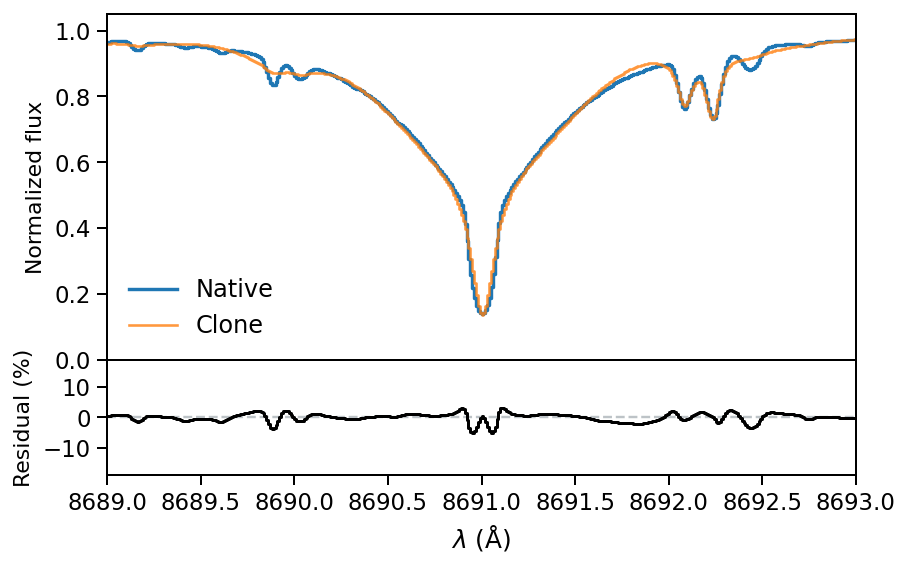

In [44]:
fig = plt.figure(figsize=(6.5, 4))

# Data - model comparison
ax = fig.add_axes((.1,.3,.8,.6))
ax.set_xticklabels([])
ax.step(wl_native, flux_native, alpha=1, lw=1.7, label='Native')
ax.step(wl_native, spec_out, alpha=0.8, lw=1.3, label='Clone')

ax.set_xlim(8689, 8693)
ax.legend(fontsize=12, loc='best', ncol=1, frameon=False)
ax.set_ylim(-0.0001, 1.05)

ax.set_ylabel('Normalized flux', fontsize=11);

# Residual plot 
ax2=fig.add_axes((.1,.1,.8,.2))    
ax2.axhline(0, linestyle='dashed', color='#bdc3c7')
ax2.step(wl_native, residual*100, alpha=1, color='k', lw=1.5)
ax2.set_xlim(8689, 8693)
ax2.set_ylim(-19, 19)
ax2.set_ylabel('Residual (%)', fontsize=11)
ax2.set_xlabel(r'$\lambda$ ($\mathrm{\AA}$)')
plt.savefig('../paper/paper1/figures/blase_clone_demo_zoom.png', bbox_inches='tight', dpi=300);

In [ ]:
wl0 = emulator.lam_centers.detach().cpu().numpy()

In [ ]:
mask = (wl0 < wl_hi) & (wl0 >wl_lo)

In [ ]:
mask.sum()

In [ ]:
mask = (wl0 < 8693) & (wl0 >8689)
mask.sum()

In [ ]:
73/0.007

In [ ]:
pixels = (wl_native < 8693) & (wl_native >8689)

In [ ]:
pixels.sum()

In [ ]:
mask = (wl_native > wl_lo) &(wl_native < wl_hi)
mask.sum() / len(wl_native)